,datum,neerslagintensiteit (mm/uur),DateTime
612,2021-09-28T00:00,0.0,2021-09-28 00:00:00
613,2021-09-28T00:05,0.0,2021-09-28 00:05:00
614,2021-09-28T00:10,0.0,2021-09-28 00:10:00
615,2021-09-28T00:15,0.0,2021-09-28 00:15:00
616,2021-09-28T00:20,0.0,2021-09-28 00:20:00
...,...,...,...
757,2021-09-28T12:06,0.0,2021-09-28 12:06:00
758,2021-09-28T12:11,0.0,2021-09-28 12:11:00
759,2021-09-28T12:16,0.0,2021-09-28 12:16:00
760,2021-09-28T12:21,0.0,2021-09-28 12:21:00


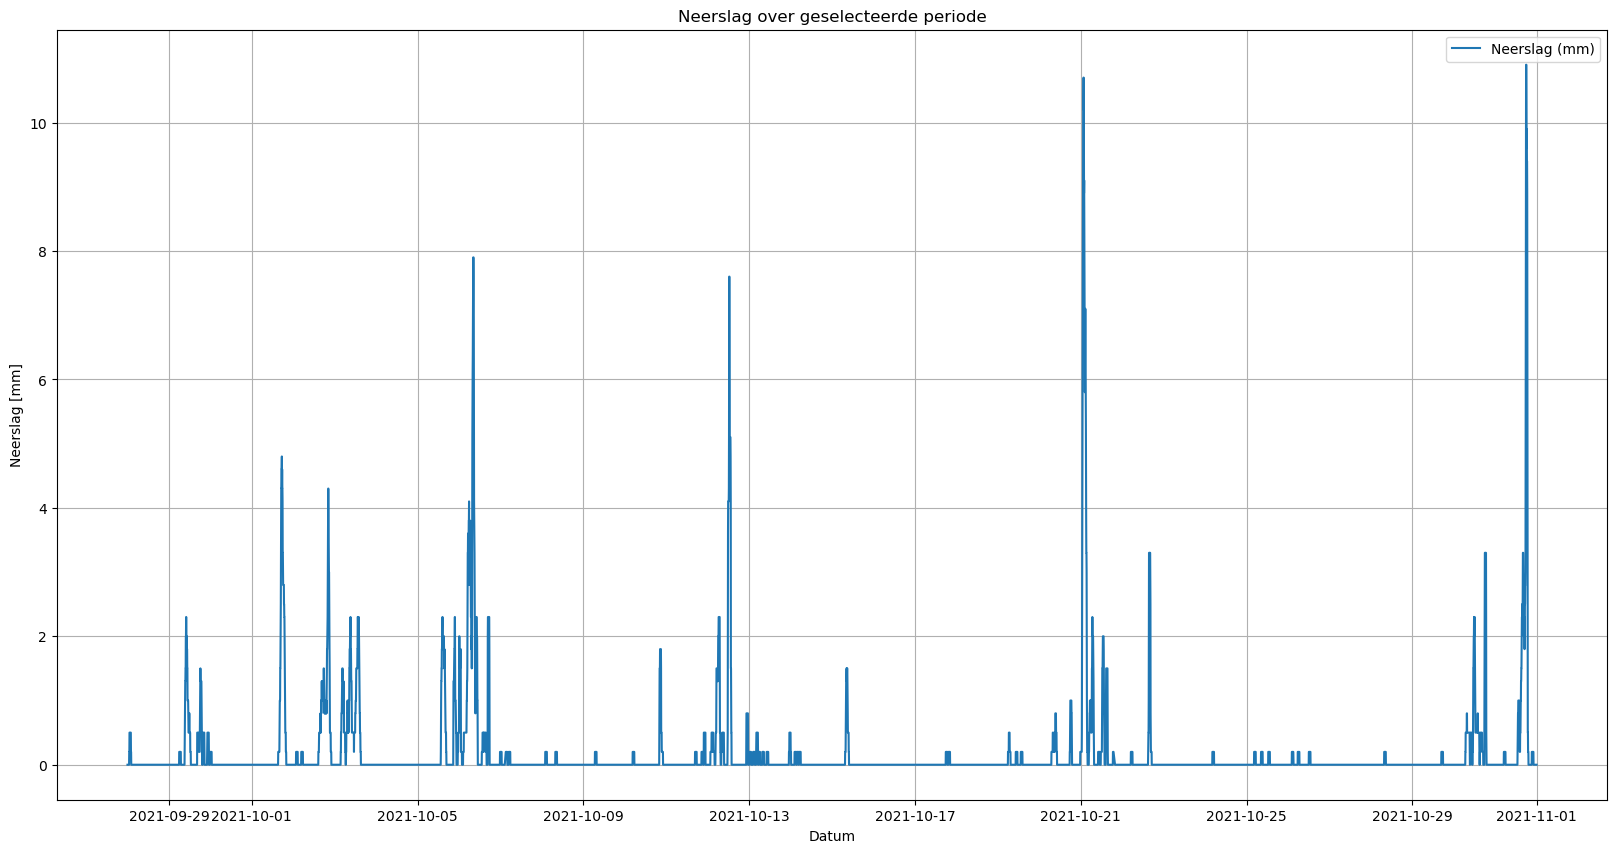

9605


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Instellen van de begin- en einddatum
begin_datum = '2021-09-28'
eind_datum = '2021-11-01'

# Filteren op de ingevoerde periode
gewenste_periode = (df_neerslag['DateTime'] >= begin_datum) & (df_neerslag['DateTime'] <= eind_datum)
df_neerslag_geselecteerd = df_neerslag.loc[gewenste_periode]

display(df_neerslag_geselecteerd.head(150))

# Plot de DateTime tegenover de RH voor de geselecteerde periode
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag_geselecteerd["DateTime"], df_neerslag_geselecteerd["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over geselecteerde periode")
plt.xlabel("Datum")
plt.ylabel("Neerslag [mm]")
plt.grid(True)
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m
df_neerslag['neerslagintensiteit (mm/uur)'] = df_neerslag['neerslagintensiteit (mm/uur)'] / 1000

print(len(df_neerslag_geselecteerd))


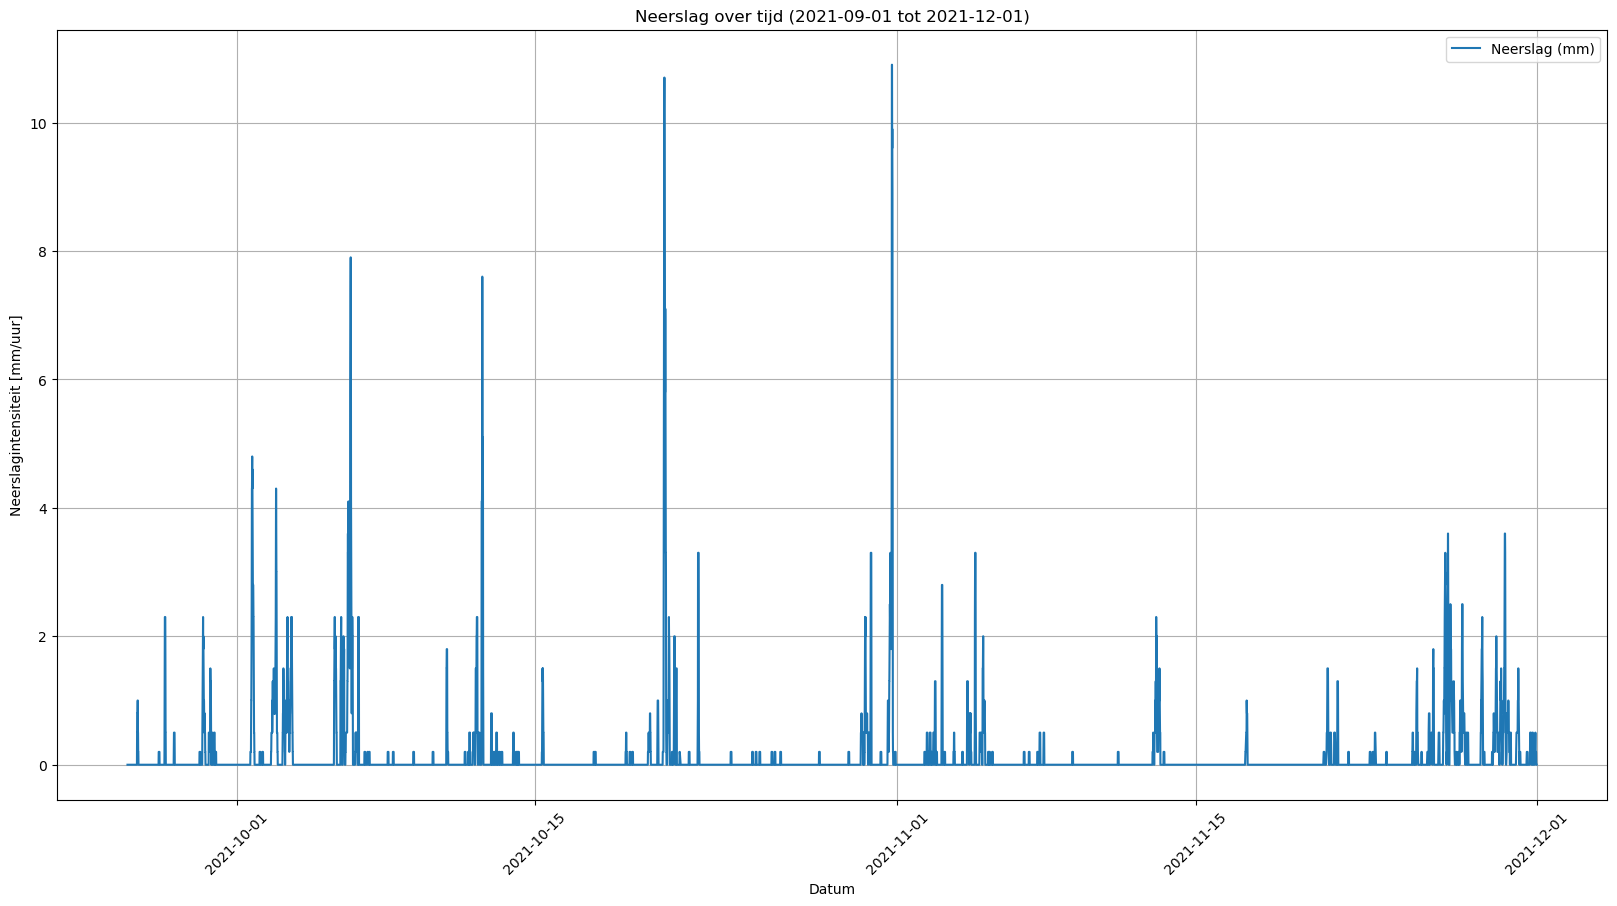

C:\Users\tiesk\AppData\Local\Temp\ipykernel_10604\2679800948.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'neerslagintensiteit (mm/uur)'] = df_filtered['neerslagintensiteit (mm/uur)'] / 1000 / 12


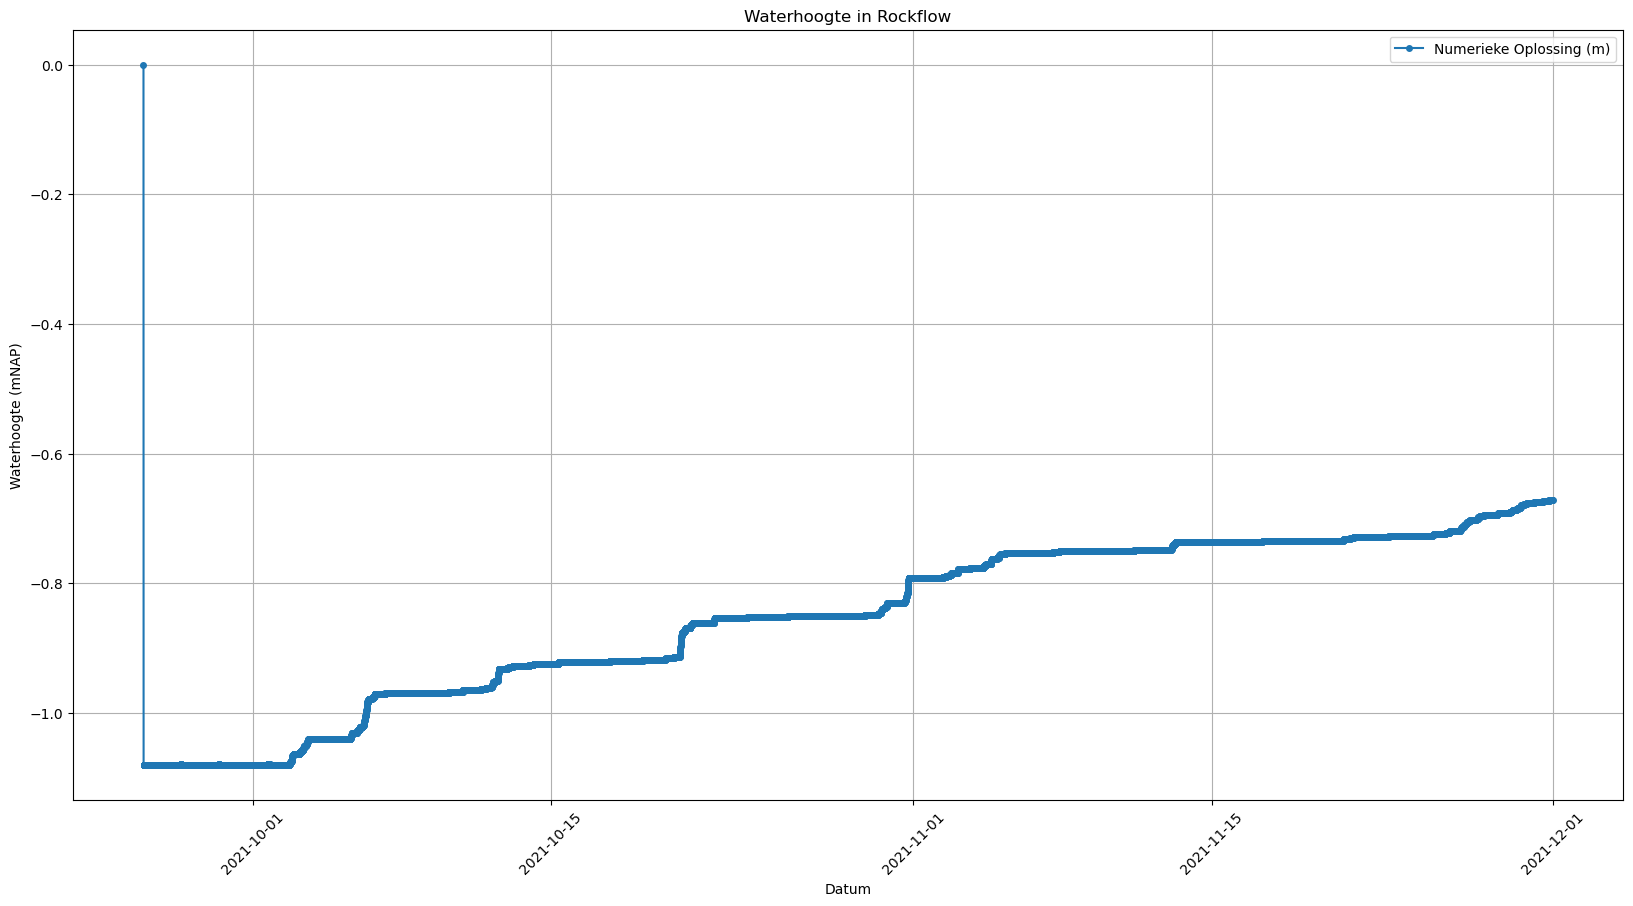

In [25]:
# Lijstje van de benodigde imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes

# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Datumfilter instellen van 2021-09-01 tot 2021-10-01
start_date = '2021-09-01'
end_date = '2021-12-01'

# Selecteer de rijen binnen het gewenste datum bereik
df_filtered = df_neerslag[(df_neerslag['DateTime'] >= start_date) & (df_neerslag['DateTime'] <= end_date)]

# Plot de DateTime tegenover de RH voor het gefilterde bereik
plt.figure(figsize=(20, 10))
plt.plot(df_filtered["DateTime"], df_filtered["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd ({} tot {})".format(start_date, end_date))
plt.xlabel("Datum")
plt.ylabel("Neerslagintensiteit [mm/uur]")
plt.grid(True)
plt.xticks(rotation=45)  # Draai datums voor betere leesbaarheid
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m, door 12 om van mm/uur naar mm/5 min te gaan
df_filtered.loc[:, 'neerslagintensiteit (mm/uur)'] = df_filtered['neerslagintensiteit (mm/uur)'] / 1000 / 12

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_filtered['neerslagintensiteit (mm/uur)'].tolist()

# Parameters
#Bergend Opp
A_hellend_dak = 660.88
A_vlak_dak = 56.12
A_rijweg_goot = 836.99
A_trottoir_goot = 532.36
A_parkeerplaatsen = 570.08
A_afstromend = A_hellend_dak + A_vlak_dak + A_rijweg_goot + A_trottoir_goot + A_parkeerplaatsen

#Rockwool
A_RW = 1337.53   #Oppervlak van het bergend pakket (m^2)
k_RW = 200/24/12 #Doorlatendheidscoëfficiënt van de rockflow (m/5min)
p_RW = 0.95      #Porositeit Rockwool
Onderkant_RW = -1.08  #In mNAP
#Drainzand
A_DZ = 0.70*180 
k_DZ = 10/24/12
p_DZ = 0.25
VMAX_DZ = 60
#Klei
A_KL = 100
k_KL = 0.05/24/12   #Doorlatendheidscoëfficiënt van de bodem (m/5min)
p_KL = 0.4

#Tijdstappen
t0 = 0
tijdstappen = len(neerslag_lijst)

#Arrays
dt = 1  # Tijdstap (5 minuten)
t = np.arange(0, tijdstappen, dt)  # Tijdstappen
V_RW = np.zeros(len(t))  # Array voor het volume water in de rockwool
H_RW = np.zeros(len(t))  # Array voor de waterhoogte in de rockwool
V_DZ = np.zeros(len(t))  # Array voor het volume water in het drainzand
H_DZ = np.zeros(len(t))  # Array voor de waterhoogte in het drainzand

# Initiële conditie
V_RW[0] = 0.0  # Initiële volume water in het rockwool(m^3)
V_DZ[0] = 0.0  # Initiële wolume water in het drainzand (m^3)

# Numerieke oplossing met behulp van de methode van Euler
for i in range(1, len(t)):
    Q_in_RW = neerslag_lijst[i] * A_afstromend 
    Q_uit_RW = min(V_RW[i-1], A_DZ * k_DZ, VMAX_DZ - V_DZ[i-1])
    Q_in_DZ = min(V_RW[i-1], A_DZ * k_DZ, VMAX_DZ - V_DZ[i-1])
    Q_uit_DZ = 0.0

    V_RW[i] = (Q_in_RW - Q_uit_RW) * dt + V_RW[i-1]
    H_RW[i] = V_RW[i] / (p_RW * A_RW) + Onderkant_RW
    V_DZ[i] = (Q_in_DZ - Q_uit_DZ) * dt + V_DZ[i-1]
    H_DZ[i] = V_DZ[i] / (p_DZ * A_DZ)

# Plot de numerieke oplossing voor waterhoogte met datums op de x-as
plt.figure(figsize=(20, 10))
plt.plot(df_filtered['DateTime'], H_RW, label='Numerieke Oplossing (m)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Datum')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Waterhoogte in Rockflow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Draai datums voor betere leesbaarheid
plt.show()

